In [1]:
#VCL PYTORCH IMPL 
import torch
import numpy as np
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
from torchvision import datasets, transforms

In [3]:
#------This class extends the Dataset class and basicly takes a Dataset [images,labels] and sort out the indexes with a specified sub_labels
#------see how it it used later to make more sense of it.
class SubDataset(Dataset): #FROM https://github.com/GMvandeVen/continual-learning/blob/master/data.py
    '''To sub-sample a dataset, taking only those samples with label in [sub_labels].
    After this selection of samples has been made, it is possible to transform the target-labels,
    which can be useful when doing continual learning with fixed number of output units.'''

    def __init__(self, original_dataset, sub_labels, target_transform=None):
        super().__init__()
        self.dataset = original_dataset
        self.sub_indeces = []
        for index in range(len(self.dataset)):
            if hasattr(original_dataset, "train_labels"):
                if self.dataset.target_transform is None:
                    label = self.dataset.train_labels[index]
                else:
                    label = self.dataset.target_transform(self.dataset.train_labels[index])
            elif hasattr(self.dataset, "test_labels"):
                if self.dataset.target_transform is None:
                    label = self.dataset.test_labels[index]
                else:
                    label = self.dataset.target_transform(self.dataset.test_labels[index])
            else:
                label = self.dataset[index][1]
            if label in sub_labels:
                self.sub_indeces.append(index)
        self.target_transform = target_transform

In [4]:
n_tasks = 5 #one for each number
classes_per_task = 2 #because n_task = 10


# prepare permutation to shuffle label-ids (to create different class batches for each random seed)
#permutation = np.random.permutation(list(range(10)))
#--------WE ACTUALLY DONT DO THE ABOVE. we always want the tasks to be the same so no permutation.
permutation = list(range(10))
#print("random permutation of labels",permutation)
#Lambda transform is a user defined transform.
#-------nothhing really happens here
target_transform = transforms.Lambda(lambda y, x=permutation: int(permutation[y]))

dataset_transform = transforms.Compose([transforms.ToTensor()])#A lambda transform to random permutation of pixels can be added here in the permutetMNIST

#-------Here the entire MNIST dataset is loaded
mnist_train = torchvision.datasets.FashionMNIST("/", train=True,
                            download=True, transform=dataset_transform, target_transform=target_transform)
mnist_test = torchvision.datasets.FashionMNIST("/", train=False,
                            download=True, transform=dataset_transform, target_transform=target_transform)

#---------- generate labels-per-task. 
labels_per_task = [list(np.array(range(classes_per_task)) + classes_per_task * task_id) for task_id in range(n_tasks)]
#print(labels_per_task)# [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]

#----------- split them up into sub-tasks
#-------we make a list where all sub dataset get put in.
#HERE IS HOW WE take out one task data and labels. this is used in the training loop:
#xtrain_set = train_datasets[task_no].dataset.data[train_datasets[task_no].sub_indeces]
#ytrain_set = train_datasets[task_no].dataset.targets[train_datasets[task_no].sub_indeces]

train_datasets = []
test_datasets = []
for labels in labels_per_task:
    #target_transform = transforms.Lambda(lambda y, x=labels[0]: y - x) if scenario=='domain' else None #We are Task-IL: task is given, is it 1 or not
    target_transform = None
    train_datasets.append(SubDataset(mnist_train, labels, target_transform=target_transform))
    test_datasets.append(SubDataset(mnist_test, labels, target_transform=target_transform))
    
#train_datasets is a list of 5 tasks with the entire dataset in each.
#Each task has the sub_indicies that is the indicies where the target value fits the task.

C:\Users\Ralle\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [5]:
###Gotta do some coresets 

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Target transform: Lambda()
12000
tensor(3)
tensor(2)
tensor(2)
tensor(3)
tensor(3)
tensor(2)
tensor(3)
tensor(2)
tensor(2)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(2)
tensor(2)
tensor(3)
tensor(3)
tensor(2)
tensor(3)
tensor(3)


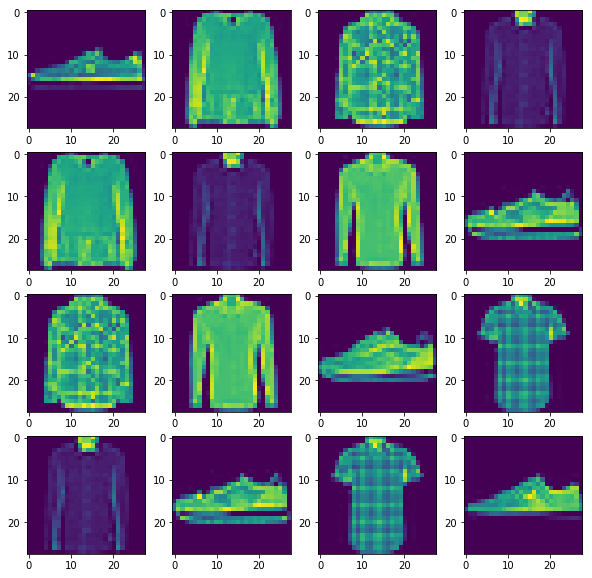

In [50]:
# this is just BS
import matplotlib.pyplot as plt

print(train_datasets[1].dataset)
print(len(train_datasets[1].sub_indeces))

for i in range(20):
    print(train_datasets[1].dataset.targets[train_datasets[1].sub_indeces[i]])

plt.figure(figsize=(10, 10))
for i in range(1,5):
    for j in range(1,5):
        plt.subplot(4,4,(j-1)*4+i)
        plt.imshow(train_datasets[3].dataset.data[train_datasets[3].sub_indeces[i*j]])
plt.show()


In [18]:
for i in range(5):
    print(len(train_datasets[i].dataset.targets[train_datasets[i].sub_indeces]))

12000
12000
12000
12000
12000


In [19]:
def get_n_true(pred,y):
    n = len(y)
    prec=0
    for i in range(n):
        pred_index = torch.argmax(pred[i])
        true_index = torch.argmax(y[i])
        if  pred_index == true_index:
            prec +=1
    return prec
        
        

In [29]:
#####THE CORESET THING  ##inspired by paper
def k_center(x_coreset, y_coreset, x_train, y_train, coreset_size):
    # Select K centers from (x_train, y_train) and add to current coreset (x_coreset, y_coreset)
    dists = np.full(x_train.shape[0], np.inf) #all dists are inf
    current_id = 0
    
    for j in range(x_train.shape[0]):
            current_dist = np.linalg.norm(x_train[j,:]-x_train[current_id,:])
            dists[j] = np.minimum(current_dist, dists[j])
            
    idx = [ current_id ]

    for i in range(1, coreset_size):
        current_id = np.argmax(dists)
        
        for j in range(x_train.shape[0]):
            current_dist = np.linalg.norm(x_train[j,:]-x_train[current_id,:])
            dists[j] = np.minimum(current_dist, dists[j])
        
        idx.append(current_id)

    x_coreset.append(x_train[idx,:])
    y_coreset.append(y_train[idx])
    x_train = np.delete(x_train, idx, axis=0)
    y_train = np.delete(y_train, idx, axis=0)

    return x_coreset, y_coreset, x_train, y_train

In [38]:
import torch
import torch.nn.functional as F
import torch.distributions as tdist
import copy
from IPython.display import clear_output

# FOR THE SPLITMNSIST MULTIHEAD PROBLEM
input_size = 28*28 #size of images
hidden_size = 256 #hidden layers size
n_hidden_layers = 2
output_size = 2
n_tasks = n_tasks # also the number of heads
init_var = 0   #This is the log(var) we use when we initiate layers. 0 works well with the other hyper parameters.
init_var_hid = 0
init_var_pri = 0 #Priors are initiated with this log(var)
n_samples = 10 #The number of samples we take from the posterior distribution to sample a new weight to use when training


torch.manual_seed(1)
np.random.seed(1)


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.criterion = torch.nn.BCEWithLogitsLoss()
        #Empty parameters to hold layers when these are added
        
        #notice that posteriors is Parameter list, so they get updated and priors is just a list.
        #i may fuck this up when i add layers or something, but as long as the priors are not updated by the optimizer we are good
        self.hidden_w_mean = torch.nn.ParameterList([])
        self.hidden_b_mean = torch.nn.ParameterList([])
        self.hidden_w_var = torch.nn.ParameterList([])
        self.hidden_b_var = torch.nn.ParameterList([])

        #And the priors
        self.pri_hidden_w_mean = []
        self.pri_hidden_b_mean = []
        self.pri_hidden_w_var = []
        self.pri_hidden_b_var = []

        #initiating hidden layers. weights are initiatet with N(0,0.1)
        for i in range(n_hidden_layers):
            if i == 0:
                inp_size = input_size
            else:
                inp_size = hidden_size
            self.hidden_w_mean.append(torch.nn.Parameter(torch.randn(inp_size,hidden_size)*0.1, requires_grad=True))
            self.hidden_b_mean.append(torch.nn.Parameter(torch.randn(hidden_size,1)*0.1, requires_grad=True))
            self.hidden_w_var.append(torch.nn.Parameter(torch.ones(inp_size,hidden_size)*init_var_hid, requires_grad=True))
            self.hidden_b_var.append(torch.nn.Parameter(torch.ones(hidden_size,1)*init_var_hid, requires_grad=True))

            #And the priors
            self.pri_hidden_w_mean.append(torch.zeros(inp_size,hidden_size))
            self.pri_hidden_b_mean.append(torch.zeros(hidden_size,1))
            self.pri_hidden_w_var.append(torch.ones(inp_size,hidden_size)*init_var_pri)
            self.pri_hidden_b_var.append(torch.ones(hidden_size,1)*init_var_pri)

       #Empty parameters to hold output layers when these are added in the add_task function. again 
        #priors will just be a list(or maybe not when we addtask() but it does not matter as long as they are not updated by optimizer)
        self.out_layers_w_mean = torch.nn.ParameterList([])
        self.out_layers_b_mean = torch.nn.ParameterList([])
        self.out_layers_w_var = torch.nn.ParameterList([])
        self.out_layers_b_var = torch.nn.ParameterList([])
        
        self.pri_out_layers_w_mean = None
        self.pri_out_layers_b_mean = None
        self.pri_out_layers_w_var = None
        self.pri_out_layers_b_var = None
        
           
    def forward(self, x, y, task_no, train=True):#y must be 1 of k encoded
        #sample from posterior using the reparameterization trick
        #from hidden layer
        batch_size = x.shape[0] 
        
        x = x.view(-1,input_size) #make it a vector
        x = x/256
        
        for i in range(n_hidden_layers):
            if train == False:   #if we are validating the network we just use the current mean of the weights. no need to sample
                hidden_w = self.hidden_w_mean[i]
                hidden_b = self.hidden_b_mean[i]
            else:
                with torch.no_grad(): #sample from N(0,1). nograd because of reparameterization trick. SEE TAHT WE take n_samples!
                    inp_size,out_size = self.hidden_w_mean[i].size()
                    hidden_w = torch.nn.Parameter(torch.randn(n_samples,inp_size,out_size))
                    hidden_b = torch.nn.Parameter(torch.randn(n_samples,out_size,1))
                
                #WE MEAN THE SAMPLES AND generate weights from them
                hidden_w = torch.add(self.hidden_w_mean[i],torch.mul(torch.mean(hidden_w,dim=0),torch.exp(0.5*self.hidden_w_var[i])))
                hidden_b = torch.add(self.hidden_b_mean[i],torch.mul(torch.mean(hidden_b,dim=0),torch.exp(0.5*self.hidden_b_var[i])))
            #then we put data through the layer. ReLU is shit when network is randomly initiatet, but sigmoid works well.(paper uses relu)
            x = F.relu(torch.tensordot(torch.transpose(hidden_w,0,1),x,([1],[1]))+hidden_b)
            x = torch.transpose(x,0,1)
        
        # WE DO the same thing as above with the output layer.
        #here we chose the layer that maches the task_no
        if train == False:
            out_w = self.out_layers_w_mean[task_no]
            out_b = self.out_layers_b_mean[task_no]
        else:        
            with torch.no_grad():
                inp_size,out_size = self.out_layers_w_mean[task_no].size()
                out_w = torch.nn.Parameter(torch.randn(n_samples,inp_size,out_size))
                out_b = torch.nn.Parameter(torch.randn(n_samples,out_size,1))
            out_w = torch.add(self.out_layers_w_mean[task_no],torch.mul(torch.mean(out_w,dim=0),torch.exp(0.5*self.out_layers_w_var[task_no])))
            out_b = torch.add(self.out_layers_b_mean[task_no],torch.mul(torch.mean(out_b,dim=0),torch.exp(0.5*self.out_layers_b_var[task_no])))
           
        #predict
        #print("x shape input",x.shape)
        
        #print("x shape input after view",x.shape)
        #print("x shape after unsqueeze",x.shape)
        #print("x type",x.type())
        
        #print(hidden_w.shape,x.shape,hidden_b.shape)
        
        x = torch.tensordot(torch.transpose(out_w,0,1),x,([1],[1]))+out_b
        
        #print(x.shape) # [2xbatch]
        #x = torch.transpose(x,0,1)
        #print("before softmax: ",x)
        pred = x
        #print("after softmax: ",pred)
        pred = torch.transpose(pred, 0, 1)
        #print("after softmax: ",pred)
        #Eq*log(likelyhood)-Eq*KL(estimated_prior/prior)
        
        
        # SEE THE loss function
        loss, kl = self.calc_loss(pred,y,task_no,batch_size)
        
        
        return pred, loss, kl
            
    def calc_loss(self,y,t,task_no,batch_size):#FROM EX 7.2:
        # 
        
        likelihood = self.criterion(y, t)
        
        kl = torch.tensor(0.)
        
        #For the KL loss i use the formula for two multivariate gaussians(but ours is just a single gaussian for each weight)
        #for i in range(n_hidden_layers):
        #    kl += torch.sum(0.5*(torch.exp(self.hidden_w_var[i]-self.pri_hidden_w_var[i]) + (self.pri_hidden_w_mean[i]-self.hidden_w_mean[i])**2/(torch.exp(self.pri_hidden_w_var[i]))-1+self.pri_hidden_w_var[i]-self.hidden_w_var[i]))
        #    kl += torch.sum(0.5*(torch.exp(self.hidden_b_var[i]-self.pri_hidden_b_var[i]) + (self.pri_hidden_b_mean[i]-self.hidden_b_mean[i])**2/(torch.exp(self.pri_hidden_b_var[i]))-1+self.pri_hidden_b_var[i]-self.hidden_b_var[i]))
        
        ##also for output layers
        #kl += torch.sum(0.5*(torch.exp(self.out_layers_w_var[task_no]-self.pri_out_layers_w_var[task_no]) + (self.pri_out_layers_w_mean[task_no]-self.out_layers_w_mean[task_no])**2/(torch.exp(self.pri_out_layers_w_var[task_no]))-1+self.pri_out_layers_w_var[task_no]-self.out_layers_w_var[task_no]))
        #kl += torch.sum(0.5*(torch.exp(self.out_layers_b_var[task_no]-self.pri_out_layers_b_var[task_no]) + (self.pri_out_layers_b_mean[task_no]-self.out_layers_b_mean[task_no])**2/(torch.exp(self.pri_out_layers_b_var[task_no]))-1+self.pri_out_layers_b_var[task_no]-self.out_layers_b_var[task_no]))
        #print("kl",kl)
        
        ################THEIR KL ALGO
        for i in range(n_hidden_layers):
            if i == 0:
                inp_size = input_size
            else:
                inp_size = hidden_size
            const_term = -0.5 * hidden_size * inp_size
            log_std_diff = 0.5 * torch.sum(self.pri_hidden_w_var[i] - self.hidden_w_var[i])
            mu_diff_term = 0.5 * torch.sum((torch.exp(self.hidden_w_var[i]) + (self.pri_hidden_w_mean[i] - self.hidden_w_mean[i])**2) / torch.exp(self.pri_hidden_w_var[i]))
            kl += const_term + log_std_diff + mu_diff_term
            
            const_term = -0.5 * hidden_size
            log_std_diff = 0.5 * torch.sum(self.pri_hidden_b_var[i] - self.hidden_b_var[i])
            mu_diff_term = 0.5 * torch.sum((torch.exp(self.hidden_b_var[i]) + (self.pri_hidden_b_mean[i] - self.hidden_b_mean[i])**2) / torch.exp(self.pri_hidden_b_var[i]))
            kl += const_term + log_std_diff + mu_diff_term
        
        
        const_term = -0.5 * hidden_size * output_size
        log_std_diff = 0.5 * torch.sum(self.pri_out_layers_w_var[task_no] - self.out_layers_w_var[task_no])
        mu_diff_term = 0.5 * torch.sum((torch.exp(self.out_layers_w_var[task_no]) + (self.pri_out_layers_w_mean[task_no] - self.out_layers_w_mean[task_no])**2) / torch.exp(self.pri_out_layers_w_var[task_no]))
        kl += const_term + log_std_diff + mu_diff_term
        
        const_term = -0.5  * output_size
        log_std_diff = 0.5 * torch.sum(self.pri_out_layers_b_var[task_no] - self.out_layers_b_var[task_no])
        mu_diff_term = 0.5 * torch.sum((torch.exp(self.out_layers_b_var[task_no]) + (self.pri_out_layers_b_mean[task_no] - self.out_layers_b_mean[task_no])**2) / torch.exp(self.pri_out_layers_b_var[task_no]))
        kl += const_term + log_std_diff + mu_diff_term
        
        kl = kl/batch_size
        ############################

        # Combining the two terms in the evidence lower bound objective (ELBO) 
        #I DONT KNOW IF THE KL needs some kind of scaling since we just added up for every weight in the network
        ELBO = torch.add(likelihood, kl) ############################
        
        #print("elbo: ",likelihood, "kl", kl)
        return ELBO, -kl
    
    def add_task(self):
        if self.pri_out_layers_w_mean is None: #if we need to add the first output layer (initiates as the hidden layers)
            self.out_layers_w_mean.append(torch.nn.Parameter(torch.randn(hidden_size,output_size)*0.1, requires_grad=True))
            self.out_layers_b_mean.append(torch.nn.Parameter(torch.randn(output_size,1)*0.1, requires_grad=True))
            self.out_layers_w_var.append(torch.nn.Parameter(torch.ones(hidden_size,output_size)*init_var, requires_grad=True))
            self.out_layers_b_var.append(torch.nn.Parameter(torch.ones(output_size,1)*init_var, requires_grad=True))
            
            self.pri_out_layers_w_mean = [torch.nn.Parameter(torch.zeros(hidden_size,output_size), requires_grad=False)]
            self.pri_out_layers_b_mean = [torch.nn.Parameter(torch.zeros(output_size,1), requires_grad=False)]
            self.pri_out_layers_w_var = [torch.nn.Parameter(torch.ones(hidden_size,output_size)*init_var_pri, requires_grad=False)]
            self.pri_out_layers_b_var = [torch.nn.Parameter(torch.ones(output_size,1)*init_var_pri, requires_grad=False)]
            
        else:#if it is not the first we initiate the means as the means for the prev layer, but the variance as we defined so we allow it to change more
            self.out_layers_w_mean.append(torch.nn.Parameter(torch.randn(hidden_size,output_size)*0.1, requires_grad=True))
            self.out_layers_b_mean.append(torch.nn.Parameter(torch.randn(output_size,1)*0.1, requires_grad=True))
            self.out_layers_w_var.append(torch.nn.Parameter(torch.ones(hidden_size,output_size)*init_var, requires_grad=True))#initialize new head as the same as previous
            self.out_layers_b_var.append(torch.nn.Parameter(torch.ones(output_size,1)*init_var, requires_grad=True))#initialize new head as the same as previous
            
            #self.out_layers_w_mean.append(torch.nn.Parameter(self.out_layers_w_mean[-1].clone().detach()))#initialize new head as the same as previous
            #self.out_layers_b_mean.append(torch.nn.Parameter(self.out_layers_b_mean[-1].clone().detach()))#initialize new head as the same as previous
            #self.out_layers_w_var.append(torch.nn.Parameter(self.out_layers_w_var[-1].clone().detach()))#initialize new head as the same as previous
            #self.out_layers_b_var.append(torch.nn.Parameter(self.out_layers_b_var[-1].clone().detach()))#initialize new head as the same as previous
            
            #self.out_layers_w_var.append(torch.nn.Parameter(torch.ones(hidden_size,output_size)*init_var, requires_grad=True))
            #self.out_layers_b_var.append(torch.nn.Parameter(torch.ones(output_size,1)*init_var, requires_grad=True))
            
            #AND THE priors as always:
            self.pri_out_layers_w_mean.append(torch.nn.Parameter(torch.zeros(hidden_size,output_size), requires_grad=False))
            self.pri_out_layers_b_mean.append(torch.nn.Parameter(torch.zeros(output_size,1), requires_grad=False))
            self.pri_out_layers_w_var.append(torch.nn.Parameter(torch.ones(hidden_size,output_size)*init_var_pri, requires_grad=False))
            self.pri_out_layers_b_var.append(torch.nn.Parameter(torch.ones(output_size,1)*init_var_pri, requires_grad=False))
            
            #self.pri_out_layers_w_mean.append(self.pri_out_layers_w_mean[-1])
            #self.pri_out_layers_b_mean.append(self.pri_out_layers_b_mean[-1])
            #self.pri_out_layers_w_var.append(self.pri_out_layers_w_var[-1])
            #self.pri_out_layers_b_var.append(self.pri_out_layers_b_var[-1])
            
    def update_prior(self,task_no):#call before backward and after forward so we have used the old ones to get loss but copy the old posterior before it is updated in backward
        for i in range(n_hidden_layers):# just copies the current mean and var into the priors in a weird way to make shure they requires grad =False
            self.pri_hidden_w_mean[i] = self.hidden_w_mean[i].clone().detach()
            self.pri_hidden_b_mean[i] = self.hidden_b_mean[i].clone().detach()
            self.pri_hidden_w_var[i] = self.hidden_w_var[i].clone().detach()
            self.pri_hidden_b_var[i] = self.hidden_b_var[i].clone().detach()

            self.pri_hidden_w_mean[i].requires_grad = False
            self.pri_hidden_b_mean[i].requires_grad = False
            self.pri_hidden_w_var[i].requires_grad = False
            self.pri_hidden_b_var[i].requires_grad = False

        self.pri_out_layers_w_mean[task_no] = self.out_layers_w_mean[task_no].clone().detach()
        self.pri_out_layers_b_mean[task_no] = self.out_layers_b_mean[task_no].clone().detach()
        self.pri_out_layers_w_var[task_no] = self.out_layers_w_var[task_no].clone().detach()
        self.pri_out_layers_b_var[task_no] = self.out_layers_b_var[task_no].clone().detach()
            
        self.pri_out_layers_w_mean[task_no].requires_grad = False
        self.pri_out_layers_b_mean[task_no].requires_grad = False
        self.pri_out_layers_w_var[task_no].requires_grad = False
        self.pri_out_layers_b_var[task_no].requires_grad = False
    
    def reset_var_and_priors(self): #This only resets the first output layer
        print(init_var_hid,init_var,init_var_pri)
        for i in range(n_hidden_layers):
            if i == 0:
                inp_size = input_size
            else:
                inp_size = hidden_size
            self.hidden_w_var[i] = torch.nn.Parameter(torch.ones(inp_size,hidden_size)*init_var_hid, requires_grad=True)
            self.hidden_b_var[i] = torch.nn.Parameter(torch.ones(hidden_size,1)*init_var_hid, requires_grad=True)
            
            self.pri_hidden_w_mean[i] = self.hidden_w_mean[i].clone().detach()
            self.pri_hidden_b_mean[i]= self.hidden_b_mean[i].clone().detach()
            self.pri_hidden_w_mean[i].requires_grad = False
            self.pri_hidden_b_mean[i].requires_grad = False
            
            self.pri_hidden_w_var[i] = torch.ones(inp_size,hidden_size)*init_var_pri
            self.pri_hidden_b_var[i] = torch.ones(hidden_size,1)*init_var_pri

            
        
        self.out_layers_w_var[0] = torch.nn.Parameter(torch.ones(hidden_size,output_size)*init_var, requires_grad=True)
        self.out_layers_b_var[0] = torch.nn.Parameter(torch.ones(output_size,1)*init_var, requires_grad=True)
        
        self.pri_out_layers_w_mean[0] = self.out_layers_w_mean[0].clone().detach()
        self.pri_out_layers_b_mean[0] = self.out_layers_b_mean[0].clone().detach()
        self.pri_out_layers_w_mean[0].requires_grad = False
        self.pri_out_layers_b_mean[0].requires_grad = False
        
        self.pri_out_layers_w_var[0] = torch.nn.Parameter(torch.ones(hidden_size,output_size)*init_var_pri, requires_grad=False)
        self.pri_out_layers_b_var[0] = torch.nn.Parameter(torch.ones(output_size,1)*init_var_pri, requires_grad=False)
            
        
        
        
net = Net()
print(net)

Net(
  (criterion): BCEWithLogitsLoss()
  (hidden_w_mean): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 784x256]
      (1): Parameter containing: [torch.FloatTensor of size 256x256]
  )
  (hidden_b_mean): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 256x1]
      (1): Parameter containing: [torch.FloatTensor of size 256x1]
  )
  (hidden_w_var): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 784x256]
      (1): Parameter containing: [torch.FloatTensor of size 256x256]
  )
  (hidden_b_var): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 256x1]
      (1): Parameter containing: [torch.FloatTensor of size 256x1]
  )
  (out_layers_w_mean): ParameterList()
  (out_layers_b_mean): ParameterList()
  (out_layers_w_var): ParameterList()
  (out_layers_b_var): ParameterList()
)


In [39]:
a = [0,1]
a =torch.tensor(a)
print([a][0],list(reversed(a)))

tensor([0, 1]) [tensor(1), tensor(0)]


In [51]:
def the_optimal_class_thing(x_data_from,y_data_from, x_data_to,y_data_to,n_samples_per_class):
    #the two classes in the new set does not need dist to each other
    #use k center to take out data_points from new set
    #x must be split into each class
    unique_classes_from = np.unique(np.array(y_data_from))
    unique_classes_to = np.unique(np.array(y_data_to))
    coreset_1_from_idx = []
    coreset_2_from_idx = []
    coreset_1_to_idx = []
    coreset_2_to_idx = []
    for i in range(len(y_data_from)):
        if y_data_from[i] == unique_classes_from[0]:
            coreset_1_from_idx.append(i)
        elif y_data_from[i] == unique_classes_from[1]:
            coreset_2_from_idx.append(i)
    for i in range(len(y_data_to)):
        if y_data_to[i] == unique_classes_to[0]:
            coreset_1_to_idx.append(i)
        elif y_data_to[i] == unique_classes_to[1]:
            coreset_2_to_idx.append(i)
            
    x1_from ,_ ,_ ,_ = k_center([], [], x_data_from[coreset_1_from_idx], y_data_from[coreset_1_from_idx], n_samples_per_class)
    x2_from ,_ ,_ ,_ = k_center([], [], x_data_from[coreset_2_from_idx], y_data_from[coreset_2_from_idx], n_samples_per_class)
    x1_to ,_ ,_ ,_ = k_center([], [], x_data_to[coreset_1_to_idx], y_data_to[coreset_1_to_idx], n_samples_per_class)
    x2_to ,_ ,_ ,_ = k_center([], [], x_data_to[coreset_2_to_idx], y_data_to[coreset_2_to_idx], n_samples_per_class)
        
    #Now get distance from from1 and 2 to to1 and 2
    dist11=0
    dist12=0
    dist21=0
    dist22=0
    for i in range(n_samples_per_class):  
        for j in range(n_samples_per_class):
            dist11 += (np.linalg.norm(x1_from[0][i,:]-x1_to[0][j,:]))/(n_samples_per_class*n_samples_per_class)
            dist12 += (np.linalg.norm(x1_from[0][i,:]-x2_to[0][j,:]))/(n_samples_per_class*n_samples_per_class)
            dist21 += (np.linalg.norm(x2_from[0][i,:]-x1_to[0][j,:]))/(n_samples_per_class*n_samples_per_class)
            dist22 += (np.linalg.norm(x2_from[0][i,:]-x2_to[0][j,:]))/(n_samples_per_class*n_samples_per_class)
    
    min_dist = np.argmin([dist11+dist22, dist12+dist21])
    
    if min_dist == 0 or min_dist == 3:
        return unique_classes_from, unique_classes_to
    else:
        return list(reversed(unique_classes_from)), unique_classes_to
    return 

    

In [53]:
#This code finds a hopefully better way to arange classes measured in relation to 0 and 1
for i in range(1,5):
    print(the_optimal_class_thing(train_datasets[i].dataset.data[train_datasets[i].sub_indeces], train_datasets[i].dataset.targets[train_datasets[i].sub_indeces],train_datasets[0].dataset.data[train_datasets[0].sub_indeces],train_datasets[0].dataset.targets[train_datasets[0].sub_indeces], 100))
#for MNIST compared to task1
#0 1
#3 2
#4 5
#7 6
#9 8
#for fashion compared to task1
#no change
#for fashion compared to task i-1
#0,1
#2,3
#4,5
#7,6
#9,8


(array([2, 3], dtype=int64), array([0, 1], dtype=int64))
(array([4, 5], dtype=int64), array([0, 1], dtype=int64))
(array([6, 7], dtype=int64), array([0, 1], dtype=int64))
(array([8, 9], dtype=int64), array([0, 1], dtype=int64))


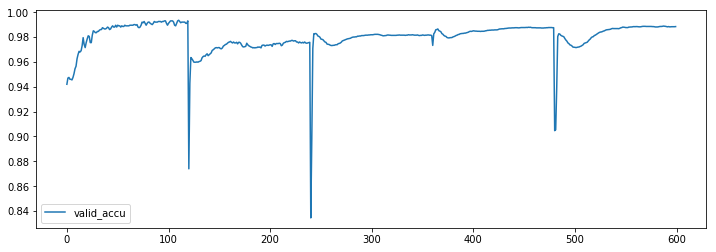

task:  4 	loss:  tensor(0.1450)
ex outvar:  tensor([-5.9882]) 	ex hidvar:  tensor([-5.8984])
ex pri outvar:  tensor([0.]) 	ex pri hidvar:  tensor([-5.8916])
ex out m:  tensor([-0.0815]) 	ex hidmean:  tensor([-0.0042])
ex pri out m:  tensor([0.]) 	ex pri hidmean:  tensor([-0.0023])
validation prec:  9884
kl:  tensor(-0.7672, grad_fn=<NegBackward>)
9884 10000


In [41]:
#THE TRAINING AND VALIDATION PART
import torch.optim as optim

no_epochs = 120
batch_size = 60000
lr = 0.001

xtest_set = [test_datasets[0].dataset.data[test_datasets[0].sub_indeces]]
xtrain_set = torch.tensor([])
ytest_set = [test_datasets[0].dataset.targets[test_datasets[0].sub_indeces]]
ytrain_set = torch.tensor([])

coreset_size = 40

#########PRE TRAINING
print("pretraining")
pre_batch_size = 64
net.add_task()
optimizer = optim.Adam(net.parameters(), lr=lr)
xtrain_set = train_datasets[0].dataset.data[train_datasets[0].sub_indeces]
ytrain_set = train_datasets[0].dataset.targets[train_datasets[0].sub_indeces]
    
for epoch in range(1):
    print("pretraing epoch", epoch)
    num_samples = len(xtrain_set)
    num_batches = int(np.ceil(num_samples / float(pre_batch_size)))
    for batch in range(num_batches):
        net.train()
        #get indexes for current batch
        idx = range(batch*pre_batch_size, np.minimum((batch+1)*pre_batch_size, num_samples))#indexes to use from batch
        X_batch_tr = xtrain_set[idx]
        y_batch_tr_raw = ytrain_set[idx]
        #TRANSFORM Y:
        y_batch_tr = torch.zeros((len(idx),2))
        for i in range(len(y_batch_tr_raw)):
            if y_batch_tr_raw[i] in [0,3,4,7,9]:
                y_batch_tr[i,0] = 1
            else: #i used this when i had 2 output neurons
                y_batch_tr[i,1] = 1

        optimizer.zero_grad()
        output, batch_loss, _ = net(X_batch_tr.type(torch.FloatTensor),y_batch_tr.type(torch.FloatTensor),0)#task no so we choose correct head. calls forward function.
        batch_loss.backward() #Update weights and biases to new posterior
        optimizer.step()            
#DONE PRE TRAINING

init_var = -6   #This is the log(var) we use when we initiate layers.
init_var_hid = -6
init_var_pri = 0

net.reset_var_and_priors()

x_coresets = []
y_coresets = []

#for plotting
test_vali = []
test_iter = []
test_i = 0
test_vali_seperate = [[],[],[],[],[]]

#target values to be class 1
distances = []
data_points = []

for task_no in range(n_tasks):
    print("TASK NUM: ",task_no)
    #Get the train and test 
    xtrain_set = train_datasets[task_no].dataset.data[train_datasets[task_no].sub_indeces]
    ytrain_set = train_datasets[task_no].dataset.targets[train_datasets[task_no].sub_indeces]
        
    
    #####The coreset thing
    if coreset_size > 0:  
        x_coresets, y_coresets, xtrain_set, ytrain_set = k_center(x_coresets, y_coresets, xtrain_set, ytrain_set, coreset_size)
    #####
    
    
    
    
    if task_no != 0: #Also whe a new taks comes we append this to the test set
        xtest_set.append(test_datasets[task_no].dataset.data[test_datasets[task_no].sub_indeces])
        ytest_set.append(test_datasets[task_no].dataset.targets[test_datasets[task_no].sub_indeces])
        
        net.add_task()#initialize a new head for the network

    #TRAIN
    optimizer = optim.Adam(net.parameters(), lr=lr) #REDEFINE OPTIMIZER AFTER LAYERS ARE ADDED!

    for epoch in range(no_epochs):
        num_samples = len(xtrain_set)
        num_batches = int(np.ceil(num_samples / float(batch_size)))
        print("num batches: ",num_batches)
        
        indexes = list(range(num_samples))
        np.random.shuffle(list(indexes))
        
        for batch in range(num_batches):
            net.train()
            #get indexes for current batch
            idx = indexes[slice(batch*batch_size, np.minimum((batch+1)*batch_size, num_samples))]#indexes to use from batch
            X_batch_tr = xtrain_set[idx]
            y_batch_tr_raw = ytrain_set[idx]
            #TRANSFORM Y:
            y_batch_tr = torch.zeros((len(idx),2))
            for i in range(len(y_batch_tr_raw)):
                if y_batch_tr_raw[i] in [0,3,4,7,9]:
                    y_batch_tr[i,0] = 1
                else: #i used this when i had 2 output neurons
                    y_batch_tr[i,1] = 1
  
            optimizer.zero_grad()
            output, batch_loss, _= net(X_batch_tr.type(torch.FloatTensor),y_batch_tr.type(torch.FloatTensor),task_no)#task no so we choose correct head. calls forward function.
            batch_loss.backward() #Update weights and biases to new posterior
            optimizer.step()            
            
            if(batch%100 == 0):#THis is just for evaluation and plotting
                #print(net)
                net.eval()
                vali_accu = 0
                n_test_samples = 0
                for i in range(len(xtest_set)):
                    task_test_no = i
                    
                    ytest_set_onehot = torch.zeros((len(ytest_set[i]),2))
                    for j in range(len(ytest_set[i])):
                        if ytest_set[i][j] in [0,3,4,7,9]:
                            ytest_set_onehot[j,0] = 1
                        else:
                            ytest_set_onehot[j,1] = 1       
                    output, _, kl = net(xtest_set[task_test_no].type(torch.FloatTensor),ytest_set_onehot.type(torch.FloatTensor),task_test_no, False)#task no so we choose correct head. calls forward function.
                    vali_accu += get_n_true(output,ytest_set_onehot)
                    n_test_samples += len(ytest_set_onehot)
                    
                #for plotting
                clear_output(wait=True)
                test_vali.append(vali_accu/n_test_samples)#i is task_no
                test_iter.append(test_i)
                test_i += 1
                                
                fig = plt.figure(figsize=(12,4))
                plt.plot(test_iter,test_vali, label='valid_accu')
                #plt.plot(test_iter,batch_loss_list)
                plt.legend()
                plt.show()
                    
                print("task: ",task_no,"\tloss: ",batch_loss.data)
                print("ex outvar: ", net.out_layers_b_var[task_no][0].data, "\tex hidvar: ", net.hidden_b_var[0][0].data)
                print("ex pri outvar: ", net.pri_out_layers_b_var[task_no][0].data, "\tex pri hidvar: ", net.pri_hidden_b_var[0][0].data)
                print("ex out m: ", net.out_layers_b_mean[task_no][0].data, "\tex hidmean: ", net.hidden_b_mean[0][0].data)
                print("ex pri out m: ", net.pri_out_layers_b_mean[task_no][0].data, "\tex pri hidmean: ", net.pri_hidden_b_mean[0][0].data)
                print("validation prec: ",vali_accu)
                print("kl: ",kl)
                print(vali_accu,n_test_samples)
    
    net.update_prior(task_no)

                
    #### The coreset thing: We only use the coresets when predicting and not when updating!
    for i in range(task_no+1):
        net_coreset = copy.deepcopy(net)
        optimizer = optim.Adam(net_coreset.parameters(), lr=lr)
        #Train on coreset 
        for j in range(no_epochs):
            num_samples = len(x_coresets[i])
            num_batches = int(np.ceil(num_samples / float(batch_size)))
            
            for batch in range(num_batches):
                net_coreset.train()
                #get indexes for current batch
                idx = range(batch*batch_size, np.minimum((batch+1)*batch_size, num_samples))#indexes to use from batch
                X_batch_tr = x_coresets[i][idx]
                y_batch_tr_raw = y_coresets[i][idx]
                #TRANSFORM Y:
                y_batch_tr = torch.zeros((len(idx),2))
                for k in range(len(y_batch_tr_raw)):
                    if y_batch_tr_raw[k] in [0,3,4,7,9]:
                        y_batch_tr[k,0] = 1
                    else:
                        y_batch_tr[k,1] = 1 

                optimizer.zero_grad()
                output, batch_loss, _ = net_coreset(X_batch_tr.type(torch.FloatTensor),y_batch_tr.type(torch.FloatTensor),i)#task no so we choose correct head. calls forward function.
                #net_coreset.update_prior(i)
                batch_loss.backward() #Update weights and biases to new posterior
                optimizer.step() 
        
        #RUN MODEL ON TEST SET
        ##Transform y
        y_batch_test_raw = test_datasets[i].dataset.targets[test_datasets[i].sub_indeces]
        y_batch_test = torch.zeros((len(y_batch_test_raw),2))
        for j in range(len(y_batch_test_raw)):
            if y_batch_test_raw[j] in [0,3,4,7,9]:
                y_batch_test[j,0] = 1
            else:
                y_batch_test[j,1] = 1  
                
        output, _, _ = net_coreset(test_datasets[i].dataset.data[test_datasets[i].sub_indeces].type(torch.FloatTensor), y_batch_test.type(torch.FloatTensor), i, False)
        test_vali_seperate[i].append([task_no, get_n_true(output,y_batch_test)/len(y_batch_test)])
        
        
        
    ####
                

#    #THIS is used when we make the last plot of the end results for each taks
#    for i in range(task_no+1):
#        y_batch_test_raw = test_datasets[i].dataset.targets[test_datasets[i].sub_indeces]
#        #TRANSFORM Y TO one hot:
#        y_batch_test = torch.zeros((len(y_batch_test_raw),1))
#        for j in range(len(y_batch_test_raw)):
#            if y_batch_test_raw[j] in [0,2,4,6,8]:
#                y_batch_test[j,0] = 1
#            #else:
#            #    y_batch_test[j,1] = 1
#        output, _, _ = net(test_datasets[i].dataset.data[test_datasets[i].sub_indeces].type(torch.FloatTensor), y_batch_test.type(torch.FloatTensor), i, False)
#        test_vali_seperate[i].append([task_no, get_precision(output,y_batch_test)])
        

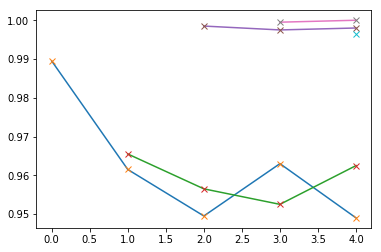

In [34]:
plt.figure()
for i in range(5):
    plt.plot(np.transpose(test_vali_seperate[i])[0],np.transpose(test_vali_seperate[i])[1])
    plt.plot(np.transpose(test_vali_seperate[i])[0],np.transpose(test_vali_seperate[i])[1],"x")
plt.show()


In [42]:
import pickle

with open('split_coreset40_fashion_taskoptim_4.pickle', 'wb') as f:
    pickle.dump(test_vali_seperate, f)




In [43]:
import pickle

with open('split_coreset40_fashion_taskoptim_4.pickle', 'rb') as f:
   test_vali_seperate_1 = pickle.load(f)


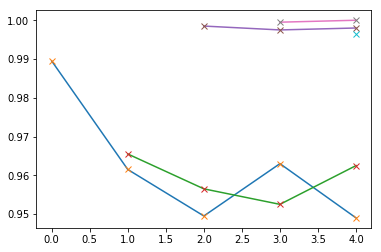

In [37]:
plt.figure()
for i in range(5):
    plt.plot(np.transpose(test_vali_seperate_1[i])[0],np.transpose(test_vali_seperate_1[i])[1])
    plt.plot(np.transpose(test_vali_seperate_1[i])[0],np.transpose(test_vali_seperate_1[i])[1],"x")
plt.show()

In [48]:
for i in net.named_parameters():
    print(i)

('hidden_w_mean.0', Parameter containing:
tensor([[-7.7002e-07, -1.1125e-05,  3.5185e-05,  ..., -3.2222e-06,
          7.7186e-06, -1.6301e-05],
        [ 9.3675e-06,  7.3920e-07, -1.0126e-05,  ...,  2.3370e-06,
          5.6567e-06,  8.9074e-06],
        [-6.6875e-06, -7.5122e-06,  8.8762e-05,  ..., -3.8555e-06,
          6.0347e-07,  1.0872e-05],
        ...,
        [ 1.1420e-05,  5.1225e-06, -3.0159e-05,  ...,  9.8955e-06,
          8.8219e-06, -1.0427e-05],
        [ 1.2787e-05,  2.9288e-05, -7.8276e-06,  ...,  6.2296e-06,
          8.0720e-06,  1.0121e-06],
        [ 1.3437e-06,  2.5653e-06, -9.3707e-06,  ..., -9.3047e-05,
         -6.5004e-06, -4.8943e-08]], requires_grad=True))
('hidden_w_mean.1', Parameter containing:
tensor([[-4.8701e-02, -6.9072e-02,  8.6756e-04,  ..., -1.7249e-02,
          3.9870e-05,  5.6056e-02],
        [ 6.9138e-04, -1.3394e-02, -3.3830e-03,  ..., -4.2165e-02,
         -5.0604e-02, -1.4167e-03],
        [ 1.3550e-04, -4.9942e-02, -1.9222e-01,  ...,  6.

        [ 6.7101e-03]], requires_grad=True))
('hidden_w_var.0', Parameter containing:
tensor([[-5.8802, -5.8802, -5.8802,  ..., -5.8802, -5.8802, -5.8802],
        [-5.8802, -5.8802, -5.8802,  ..., -5.8802, -5.8802, -5.8802],
        [-5.8802, -5.8802, -5.8802,  ..., -5.8802, -5.8802, -5.8802],
        ...,
        [-5.8802, -5.8802, -5.8802,  ..., -5.8802, -5.8802, -5.8802],
        [-5.8802, -5.8802, -5.8802,  ..., -5.8802, -5.8802, -5.8802],
        [-5.8802, -5.8802, -5.8802,  ..., -5.8802, -5.8802, -5.8802]],
       requires_grad=True))
('hidden_w_var.1', Parameter containing:
tensor([[-5.8801, -5.8784, -5.8801,  ..., -5.8815, -5.8802, -5.8799],
        [-5.8800, -5.8802, -5.8801,  ..., -5.8787, -5.8800, -5.8807],
        [-5.8802, -5.8803, -5.8802,  ..., -5.8801, -5.8802, -5.8801],
        ...,
        [-5.8803, -5.8811, -5.8801,  ..., -5.8796, -5.8801, -5.8806],
        [-5.8802, -5.8802, -5.8802,  ..., -5.8802, -5.8802, -5.8802],
        [-5.8802, -5.8801, -5.8802,  ..., -5.880

        [-5.8782]], requires_grad=True))
('out_layers_w_mean.0', Parameter containing:
tensor([[ 2.0165e-03],
        [-1.7265e-01],
        [-1.7662e-03],
        [ 6.0971e-05],
        [-2.1901e-02],
        [-1.1287e-05],
        [-4.3244e-02],
        [-2.7533e-01],
        [ 1.0805e-02],
        [-1.5046e-01],
        [-2.3073e-01],
        [ 2.2659e-01],
        [ 1.8993e-01],
        [ 4.7582e-02],
        [ 3.1509e-02],
        [ 2.3535e-02],
        [-2.1575e-01],
        [-7.2218e-02],
        [-9.3406e-03],
        [ 4.8632e-02],
        [-1.6986e-02],
        [-1.0963e-01],
        [-4.5792e-02],
        [-1.0618e-01],
        [-1.0393e-01],
        [-2.4567e-01],
        [ 4.0582e-02],
        [-1.6268e-01],
        [ 7.7381e-03],
        [-3.3809e-03],
        [-3.3744e-05],
        [-1.5984e-01],
        [ 1.8125e-02],
        [ 1.4298e-01],
        [-1.8286e-01],
        [ 1.7189e-01],
        [-2.0789e-01],
        [ 1.0886e-01],
        [ 1.2701e-02],
        [ 2.7566

        [-4.7103e-02]], requires_grad=True))
('out_layers_w_mean.2', Parameter containing:
tensor([[-2.5595e-02],
        [-1.7957e-01],
        [ 1.7572e-03],
        [ 1.9149e-04],
        [-2.2487e-02],
        [ 3.8739e-05],
        [-1.0704e-01],
        [-2.6382e-01],
        [ 2.8660e-02],
        [-1.6752e-01],
        [-2.3961e-01],
        [ 2.3455e-01],
        [ 2.1700e-01],
        [ 3.4622e-02],
        [ 7.3774e-02],
        [ 3.6391e-02],
        [-2.0233e-01],
        [-6.2057e-02],
        [-5.1069e-02],
        [ 5.4148e-02],
        [-1.8493e-02],
        [-1.1473e-01],
        [-4.1932e-02],
        [-9.9094e-02],
        [-1.1776e-01],
        [-2.3381e-01],
        [ 8.1953e-02],
        [-1.6519e-01],
        [-3.7347e-03],
        [-1.0247e-03],
        [-3.4914e-05],
        [-1.7858e-01],
        [ 6.4974e-03],
        [ 1.5321e-01],
        [-1.9206e-01],
        [ 1.6304e-01],
        [-2.0761e-01],
        [ 1.3125e-01],
        [ 4.8443e-02],
        [ 5.

        [-6.8524e-02]], requires_grad=True))
('out_layers_w_mean.4', Parameter containing:
tensor([[-3.0061e-02],
        [-1.8550e-01],
        [ 3.6409e-03],
        [ 1.8445e-04],
        [-2.3359e-02],
        [ 6.1399e-05],
        [-1.1291e-01],
        [-2.6698e-01],
        [ 2.7116e-02],
        [-1.7200e-01],
        [-2.4335e-01],
        [ 2.3395e-01],
        [ 2.1410e-01],
        [ 3.4118e-02],
        [ 6.9820e-02],
        [ 3.4166e-02],
        [-1.9917e-01],
        [-7.2559e-02],
        [-4.1664e-02],
        [ 5.4154e-02],
        [-1.8498e-02],
        [-1.2105e-01],
        [-4.5167e-02],
        [-1.1252e-01],
        [-1.2613e-01],
        [-2.4525e-01],
        [ 8.1809e-02],
        [-1.5854e-01],
        [-5.7806e-03],
        [ 3.7710e-04],
        [-4.4191e-05],
        [-1.9812e-01],
        [ 1.3910e-02],
        [ 1.5594e-01],
        [-1.8489e-01],
        [ 1.5601e-01],
        [-2.0328e-01],
        [ 1.2378e-01],
        [ 4.6442e-02],
        [ 4.

        [-5.8708]], requires_grad=True))
('out_layers_w_var.1', Parameter containing:
tensor([[-5.8766],
        [-5.8710],
        [-5.8786],
        [-5.8801],
        [-5.8800],
        [-5.8801],
        [-5.8840],
        [-5.8752],
        [-5.8791],
        [-5.8763],
        [-5.8657],
        [-5.8680],
        [-5.8785],
        [-5.8694],
        [-5.8762],
        [-5.8803],
        [-5.8712],
        [-5.8640],
        [-5.8797],
        [-5.8801],
        [-5.8801],
        [-5.8653],
        [-5.8715],
        [-5.8768],
        [-5.8720],
        [-5.8698],
        [-5.8782],
        [-5.8597],
        [-5.8803],
        [-5.8813],
        [-5.8801],
        [-5.8695],
        [-5.8786],
        [-5.8800],
        [-5.8685],
        [-5.8788],
        [-5.8812],
        [-5.8769],
        [-5.8654],
        [-5.8703],
        [-5.8690],
        [-5.8787],
        [-5.8769],
        [-5.8801],
        [-5.8706],
        [-5.8797],
        [-5.8797],
        [-5.8715],
  

        [-5.8752]], requires_grad=True))
('out_layers_w_var.3', Parameter containing:
tensor([[-5.8761],
        [-5.8590],
        [-5.8774],
        [-5.8802],
        [-5.8799],
        [-5.8802],
        [-5.8896],
        [-5.8752],
        [-5.8786],
        [-5.8753],
        [-5.8639],
        [-5.8670],
        [-5.8779],
        [-5.8656],
        [-5.8716],
        [-5.8808],
        [-5.8623],
        [-5.8631],
        [-5.8835],
        [-5.8802],
        [-5.8802],
        [-5.8712],
        [-5.8690],
        [-5.8806],
        [-5.8746],
        [-5.8697],
        [-5.8842],
        [-5.8527],
        [-5.8792],
        [-5.8799],
        [-5.8802],
        [-5.8675],
        [-5.8765],
        [-5.8797],
        [-5.8756],
        [-5.8797],
        [-5.8915],
        [-5.8741],
        [-5.8655],
        [-5.8722],
        [-5.8751],
        [-5.8821],
        [-5.8715],
        [-5.8814],
        [-5.8830],
        [-5.8791],
        [-5.8759],
        [-5.8683],
  

        [-5.8766]], requires_grad=True))
('out_layers_b_var.0', Parameter containing:
tensor([[-5.8721]], requires_grad=True))
('out_layers_b_var.1', Parameter containing:
tensor([[-5.8816]], requires_grad=True))
('out_layers_b_var.2', Parameter containing:
tensor([[-5.8872]], requires_grad=True))
('out_layers_b_var.3', Parameter containing:
tensor([[-5.8926]], requires_grad=True))
('out_layers_b_var.4', Parameter containing:
tensor([[-5.8923]], requires_grad=True))


In [18]:
print(net.named_parameters)

<bound method Module.named_parameters of Net()>


In [18]:
torch.log(torch.tensor(0.0024))

tensor(-6.0323)

In [30]:
print(net.out_layers_b_var[0].requires_grad)
print(net.pri_out_layers_b_var[0].requires_grad)


True
False


In [111]:
for i in net.named_parameters():
    print(i)
    

('hidden_w_mean.0', Parameter containing:
tensor([[ 2.1353, -2.3715,  2.3291,  ..., -2.3068,  2.3694,  2.3030],
        [ 2.3663, -2.2922,  2.3625,  ..., -2.3557, -2.3699, -2.3070],
        [ 2.3397,  2.3608,  2.2949,  ..., -2.1888,  2.3516,  2.3501],
        ...,
        [ 2.3077, -2.3618, -2.2659,  ..., -2.3371, -2.3140,  2.2923],
        [ 2.3638, -2.3181, -2.3490,  ...,  2.3543,  2.3608, -2.3579],
        [-2.3075, -2.3575, -2.3455,  ...,  2.3712, -2.3460,  2.3696]],
       requires_grad=True))
('hidden_w_mean.1', Parameter containing:
tensor([[-0.2620,  0.3067, -0.0851,  ..., -0.1688,  0.1854,  0.1521],
        [ 1.0431,  2.3428,  0.9990,  ...,  2.3702,  2.2967,  2.1707],
        [ 0.1489,  0.1878, -0.1783,  ...,  0.3391,  0.3604,  0.5605],
        ...,
        [ 2.0066,  2.3320, -0.0949,  ..., -2.3012, -2.3646, -2.3490],
        [ 1.0625,  0.3373, -0.0715,  ..., -0.3154,  1.1491,  0.8978],
        [ 1.0238,  0.9340, -0.1178,  ..., -1.0098, -1.0133, -0.9456]],
       requires_grad

        [ 1.7611]], requires_grad=True))
('hidden_w_var.0', Parameter containing:
tensor([[-2.0060, -2.0060, -2.0060,  ..., -2.0060, -2.0060, -2.0060],
        [-2.0060, -2.0060, -2.0060,  ..., -2.0060, -2.0060, -2.0060],
        [-2.0060, -2.0060, -2.0060,  ..., -2.0060, -2.0060, -2.0060],
        ...,
        [-2.0060, -2.0060, -2.0060,  ..., -2.0060, -2.0060, -2.0060],
        [-2.0060, -2.0060, -2.0060,  ..., -2.0060, -2.0060, -2.0060],
        [-2.0060, -2.0060, -2.0060,  ..., -2.0060, -2.0060, -2.0060]],
       requires_grad=True))
('hidden_w_var.1', Parameter containing:
tensor([[-2.0043, -1.9662, -1.9985,  ..., -2.0133, -2.0021, -2.0196],
        [-1.9822, -2.0060, -2.0309,  ..., -2.0060, -2.0060, -2.0060],
        [-1.9854, -2.0167, -1.9416,  ..., -2.0111, -2.0151, -1.9843],
        ...,
        [-2.0060, -2.0061, -2.0152,  ..., -2.0060, -2.0060, -2.0062],
        [-2.0036, -2.0177, -1.9933,  ..., -2.0207, -1.9812, -2.0193],
        [-1.9610, -2.0431, -1.9964,  ..., -2.0184, -

        [-2.0059]], requires_grad=True))
('out_layers_w_mean.0', Parameter containing:
tensor([[-0.1903],
        [ 0.0262],
        [-0.0187],
        [ 0.0391],
        [-0.0975],
        [ 0.1049],
        [-0.0994],
        [ 0.0796],
        [ 0.1510],
        [-0.2374],
        [ 0.1518],
        [ 0.1402],
        [ 0.1292],
        [ 0.0045],
        [ 0.0320],
        [-0.0529],
        [-0.1723],
        [-0.0487],
        [-0.0101],
        [-0.1039],
        [ 0.0980],
        [-0.0898],
        [ 0.0149],
        [-0.2111],
        [-0.2005],
        [-0.0352],
        [-0.0243],
        [ 0.0324],
        [ 0.1276],
        [-0.0008],
        [-0.0485],
        [ 0.0467],
        [-0.1710],
        [-0.0421],
        [ 0.1007],
        [-0.0359],
        [ 0.0170],
        [-0.0017],
        [ 0.0028],
        [ 0.1358],
        [ 0.1168],
        [ 0.0400],
        [-0.1053],
        [ 0.1915],
        [-0.0676],
        [-0.1115],
        [ 0.0798],
        [-0.1054],
 

        [-0.0815]], requires_grad=True))
('out_layers_w_mean.2', Parameter containing:
tensor([[-0.1903],
        [ 0.0262],
        [-0.0187],
        [ 0.0391],
        [-0.0975],
        [ 0.1049],
        [-0.0994],
        [ 0.0796],
        [ 0.1510],
        [-0.2374],
        [ 0.1518],
        [ 0.1402],
        [ 0.1292],
        [ 0.0045],
        [ 0.0320],
        [-0.0529],
        [-0.1723],
        [-0.0487],
        [-0.0101],
        [-0.1039],
        [ 0.0980],
        [-0.0898],
        [ 0.0149],
        [-0.2111],
        [-0.2005],
        [-0.0352],
        [-0.0243],
        [ 0.0324],
        [ 0.1276],
        [-0.0008],
        [-0.0485],
        [ 0.0467],
        [-0.1710],
        [-0.0421],
        [ 0.1007],
        [-0.0359],
        [ 0.0170],
        [-0.0017],
        [ 0.0028],
        [ 0.1358],
        [ 0.1168],
        [ 0.0400],
        [-0.1053],
        [ 0.1915],
        [-0.0676],
        [-0.1115],
        [ 0.0798],
        [-0.1054],
 

        [-2.]], requires_grad=True))
('out_layers_w_var.1', Parameter containing:
tensor([[-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.],
   

In [27]:
a = [1,2,3,4]
print(a[slice(1,4)])
print(a[0])

[2, 3, 4]
1


In [34]:
for i in range(1):
    print(i)

0
